## Selecting $k$ for $k$-NN regression

**(A crash course in hyperparameter tuning)**

In this notebook we will show you a method for selecting the number of neighbors, $k$, to be used in the $k$-NN regression problem. This is an introduction to the broader topic of **hyperparameter tuning** in machine learning algorithms. 

$k$ is, as we say, a ***hyperparameter*** of the algorithm. A hyperparameter is a parameter (sorry, it is a confusing name) of the model/algorithm that cannot be learned from the data during training, and has to be externally set by us (or chatGPT). This, as we are going to see, does not mean that we do not have ways to set the best hyperparameters, just that they are not automatically being learned during the training of an ML model. 

This is in contrast to the **parameters** (usually weights) that are being learned during training. In fact, $k$-NN **does not** have any trainable parameters. As we say, it is a *lazy learner*. It also has only one hyperparameter, $k$.

To make the distinction between **hyperparameters** and **parameters** more clear, consider a polynomial regression of the form:

\begin{equation}
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots + \beta_n x^n
\end{equation}

In this case the **hyperparameter** is the order of the polynomial to be used, $n$, (which we set before learning) while the model **parameters** are the coefficients $\beta$, that are being learned during training.

More complex ML algorithms that you are going to meet in the future have more than one hyperparameters, and finding the best value to use may be quite challenging/computationally expensive.

In [1]:
# Load python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Load the dataset

In [2]:
data = pd.read_csv("Advertising.csv")

data.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


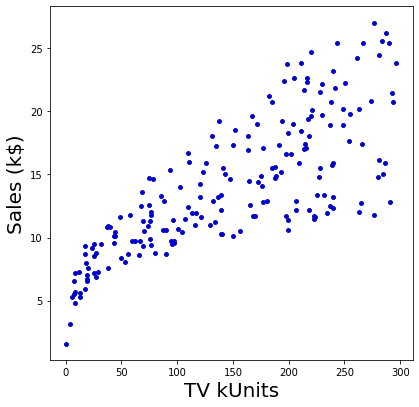

In [18]:
# Dependent variable: sales
# Independent variable: TV units
x = data['TV'].values
y = data['sales'].values


# Make plot
plt.figure(figsize=(6.5, 6.5))

plt.scatter(x,y,s=15,color='mediumblue')
plt.xlabel('TV kUnits',fontsize=20)
plt.ylabel('Sales (k$)',fontsize=20)
plt.show()

#### Split into training-validation-test sets

In [23]:
x_train = x[:100];y_train = y[:100] #Training set
x_val = x[100:160];y_val = y[100:160] #Validation set
x_test = x[160:];y_test = y[160:] #Test set

Note that the dataset is quite small and thus, generally, our results may not be that robust.
For small datasets, instead of using a separate validation set for hyperparameter tuning, we can use the **cross validation** method that you are going to see in a future lecture.

We want to make sure that the examples(=datapoints) are **randomly distributed among the three sets**.

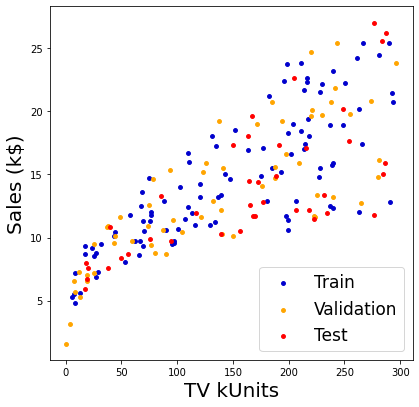

In [25]:
# Make plot
plt.figure(figsize=(6.5, 6.5))

plt.scatter(x_train,y_train,s=15,color='mediumblue',label='Train')
plt.scatter(x_val,y_val,s=15,color='orange',label='Validation')
plt.scatter(x_test,y_test,s=15,color='red',label='Test')

plt.xlabel('TV kUnits',fontsize=20)
plt.ylabel('Sales (k$)',fontsize=20)
plt.legend(frameon=True, loc='lower right', fontsize=17)
plt.show()

## $k$-NN function

Here we have a function that implements $k$-NN for regression from scratch.
`scikit-learn` has a function called `sklearn.neighbors.KNeighborsRegressor` that can perform this regression, but for a simple algorithm like this, we can easily write our own function.

Specifically, it accepts a training set of points (features and labels) and a set of points whose $y$ values we want to predict. It also works for different $k$ values.

In [37]:
def knn_regression(X_train, y_train, X_test, k):
    """
    Perform kNN regression in one dimension.
    
    Parameters:
        - X_train: array-like, training data points
        - y_train: array-like, target values for training data points
        - X_test: array-like, test data points
        - k: int, number of nearest neighbors to consider
        
    Returns:
        - y_pred: array-like, predicted target values for test data points
    """
    # calculate distances between test points and training points
    distances = np.abs(X_train - X_test[:, np.newaxis])
    # find k nearest neighbors for each test point
    k_nearest_indices = np.argpartition(distances, k, axis=1)[:, :k]
    # predict the target value for each test point as the average of the target values of its k nearest neighbors
    y_pred = np.mean(y_train[k_nearest_indices], axis=1)
    return y_pred

Fun fact: **The above code was actually written by ChatGPT!!**

### Select best $k$

We are going to select the best $k$ (number of neighbors) value to use based on the performance of $k$-NN trained on the training set and evaluated on the validation set, for different values of $k$.

How are we going to evaluate the performance? 

We can estimate the *mean absolute error* (note: there are other options, too, like the mean squared error, root mean squared error etc):

\begin{equation}
\mbox{MAE} = \frac{1}{n}\sum_i^n |\hat{y}_i - y_i|,
\end{equation}

where $\hat{y}$ the predicted and $y$ the true value.

In [40]:
def MAE(y_pred,y_true):
    """Function that gets the true and predicted y values and
    returns the Mean Absolute Error
    """
    return np.mean(np.abs(y_pred-y_true))

Note: The above function was **not** written by ChatGPT!!!


Now we run $k$-NN for $k$ in the range [1-10] (since our training set is equal to 100 it does not make much sense to go to a very large number of k).

In [75]:
MAEs = np.zeros(10)

# k=11 is not included
for k in range(1,11):
    
    # Get predictions for current k 
    # Predictions are on the **validation** set
    y_pred_k = knn_regression(x_train,y_train,x_val,k)
    
    # calculate MAE and store it
    # Note we use k-1 as index here for MAE
    MAEs[k-1] = MAE(y_pred_k,y_val)

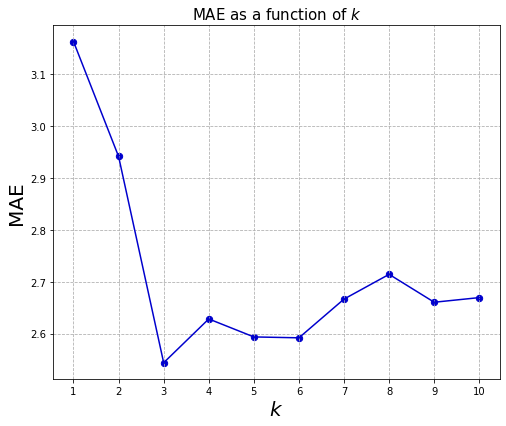

In [78]:
# Define an array of k values to be used on the x axis
ks = np.arange(1,11)


# Make plot
plt.figure(figsize=(8, 6.5))

plt.scatter(ks,MAEs,s=40,color='mediumblue')
plt.plot(ks,MAEs,c='mediumblue')
plt.grid(ls='--')
plt.title('MAE as a function of $k$',fontsize=15)
plt.xlabel(r'$k$', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(ks)
plt.show()

Beautiful, isn't it?? We can clearly see that the optimal $k$, that minimizes the MAE is $k=3$, that gives a MAE a little bit less than $2.6$.

Ok, as we said, it does not make much sense to consider $k>10$ for a training dataset of 100 points (notice: on the other hand, if our training set was really large, probably, a much larger number of neighbors could probably make **a lot** of sense - always get a feeling of your data). But how the plot would look like if we considered up to 80 nearest neighbors? Let's check, just for fun!

In [79]:
MAEs = np.zeros(80)

# k=11 is not included
for k in range(1,81):
    
    # Get predictions for current k 
    # Predictions are on the **validation** set
    y_pred_k = knn_regression(x_train,y_train,x_val,k)
    
    # calculate MAE and store it
    # Note we use k-1 as index here for MAE
    MAEs[k-1] = MAE(y_pred_k,y_val)

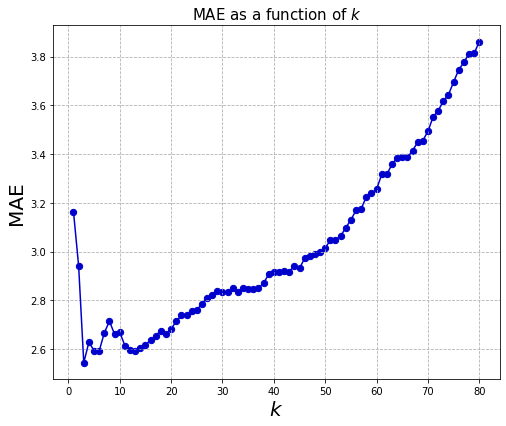

In [80]:
# Define an array of k values to be used on the x axis
ks = np.arange(1,81)


# Make plot
plt.figure(figsize=(8, 6.5))

plt.scatter(ks,MAEs,s=40,color='mediumblue')
plt.plot(ks,MAEs,c='mediumblue')
plt.grid(ls='--')
plt.title('MAE as a function of $k$',fontsize=15)
plt.xlabel(r'$k$', fontsize=20)
plt.ylabel('MAE', fontsize=20)
#plt.xticks(ks)
plt.show()

What do we have here? A nice illustration of the **Bias-Variance trade-off**!!

### Evaluate on the test set

Now that we have selected the optimal value of $k$ ($k=3$), the final step is to train the algorithm for that value of $k$ and evaluate on the test set.

In [95]:
# predict values on the test set for k=3 
y_preds = knn_regression(x_train,y_train,x_test,3)

# Estimate MAE
MAE_test = MAE(y_preds,y_test)

# Print
print('MAE on the test set:', MAE_test)

MAE on the test set: 3.3841666666666668


Question: Why is this value so different than what we had on the test set? Can we do anything about that? 

Try to split the dataset differently, use other metrics (like RMSE), other datasets... Also check the resampling methods in a future lecture....